# Data Load

In [1]:
! pip install lightgbm==3.0

     |████████████████████████████████| 1.8MB 13.1MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [2]:
! pip install catboost

     |████████████████████████████████| 66.3MB 56kB/s 


In [ ]:
! pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [344]:
train_data=pd.read_csv('/content/drive/MyDrive/hackerearth comp1/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/hackerearth comp1/test.csv')

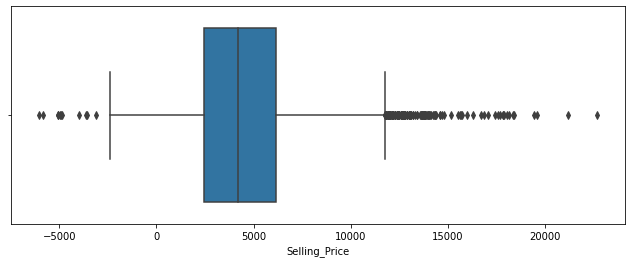

In [ ]:
fig=plt.figure(figsize=(11,4))
sns.boxplot(train_data['Selling_Price'])

In [345]:
train_data.drop(train_data[train_data['Selling_Price']>18300].index,axis=0,inplace=True)

In [346]:
train_data.drop(train_data[train_data['Selling_Price']<0].index,axis=0,inplace=True)

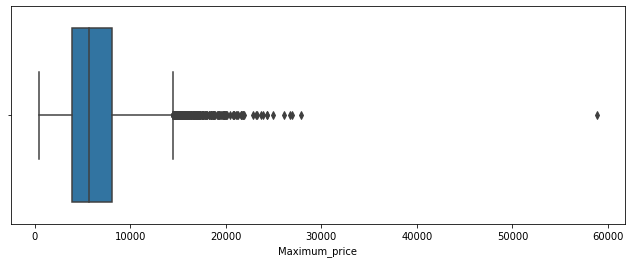

In [7]:
fig=plt.figure(figsize=(11,4))
sns.boxplot(train_data['Maximum_price'])

In [347]:
train_data.drop(train_data[train_data['Maximum_price']>25000].index,axis=0,inplace=True)

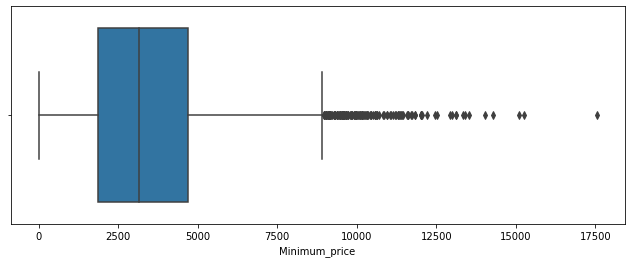

In [9]:
fig=plt.figure(figsize=(11,4))
sns.boxplot(train_data['Minimum_price'])

In [348]:
train_data.drop(train_data[train_data['Minimum_price']>11300].index,axis=0,inplace=True)

# Treating Outliers

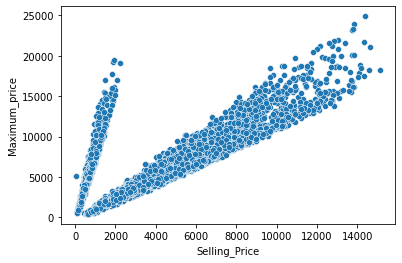

In [11]:
sns.scatterplot(train_data['Selling_Price'],train_data['Maximum_price'])

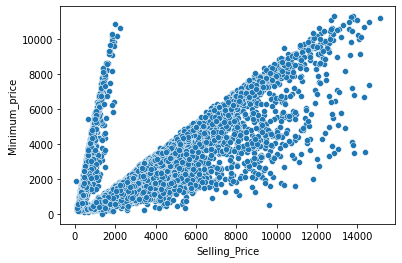

In [12]:
sns.scatterplot(train_data['Selling_Price'],train_data['Minimum_price'])

In [349]:
train_data.drop(train_data[(train_data['Minimum_price']<2000) & (train_data['Selling_Price']>9500)].index,axis=0,inplace=True)

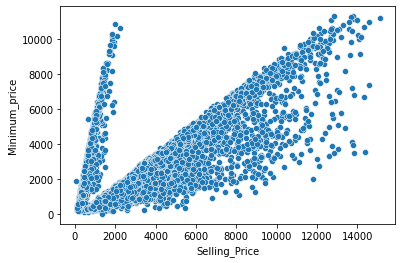

In [15]:
sns.scatterplot(train_data['Selling_Price'],train_data['Minimum_price'])

In [23]:
train_data.shape, test_data.shape

((6307, 15), (3430, 14))

# Data Preprocessing

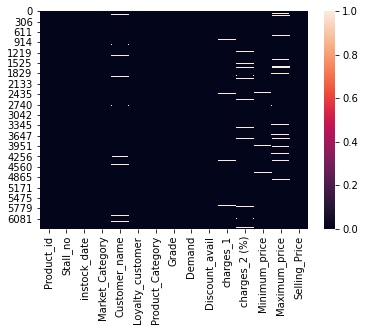

In [ ]:
sns.heatmap(pd.isnull(train_data))

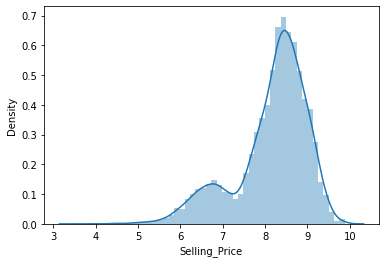

In [ ]:
sns.distplot(np.log(train_data['Selling_Price']))

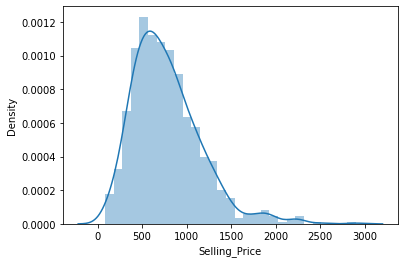

In [ ]:
sns.distplot(train_data[train_data['Discount_avail']==1]['Selling_Price'])

In [24]:
train_data[train_data['Discount_avail']==0]['Selling_Price'].median(), train_data[train_data['Discount_avail']==0]['Selling_Price'].mean()

(4667.763177000001, 5135.082039399894)

In [350]:
###******************
 
def impute_selling(cols):
  a=cols[0]
  b=cols[1]
  if pd.isnull(b):
    if a==0:
      return 4668
    else:
      return 709
  else:
    return b
 
train_data['Selling_Price']=train_data[['Discount_avail','Selling_Price']].apply(impute_selling,axis=1)

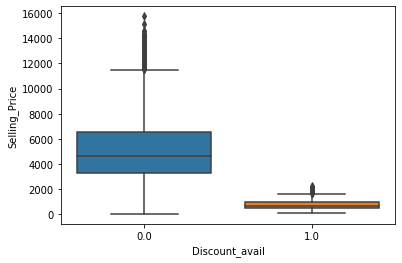

In [ ]:
sns.boxplot(train_data['Discount_avail'],train_data['Selling_Price'])

In [351]:
###**********************
 
def impute_discount(cols):
  dis=cols[0]
  tar=cols[1]
  if pd.isnull(dis):
    if tar>2300:
      return 0
    else:
      return 1
  else:
    return dis
 
train_data['Discount_avail']=train_data[['Discount_avail','Selling_Price']].apply(impute_discount,axis=1)

In [352]:
###*********************
Y=train_data['Selling_Price']

In [353]:
###***********************
total_df=pd.concat([train_data.drop('Selling_Price',axis=1),test_data],axis=0,ignore_index=True)

In [ ]:
total_df.shape

(9733, 14)

In [ ]:
total_df.info()

In [354]:
## Rejecting this columns would be better 
total_df.drop('Customer_name',axis=1,inplace=True)

### Filling Charges1 w.r.t. Charges_2

In [ ]:
fig=plt.figure(figsize=(10,6))
sns.boxplot(total_df['charges_2 (%)'],total_df['charges_1'])

In [ ]:
total_df['charges_2 (%)'].value_counts()

In [355]:
###charges1 and charges2
 
def impute_charges1(cols):
  ch1=cols[0]
  ch2=cols[1]
  if pd.isnull(ch1):
    return total_df[total_df['charges_2 (%)']==ch2]['charges_1'].median()
  else:
    return ch1
 
total_df['charges_1']=total_df[['charges_1','charges_2 (%)']].apply(impute_charges1,axis=1)
 
def impute_charges2(cols):
  ch1=cols[0]
  ch2=cols[1]
  if pd.isnull(ch2):
    if ch1<=220:
      return 7.0
    elif ch1>220:
      return 14.0
  else:
    return ch2
 
total_df['charges_2 (%)']=total_df[['charges_1','charges_2 (%)']].apply(impute_charges2,axis=1)
 
total_df['charges_2 (%)']=total_df['charges_2 (%)'].fillna(14.0)
 
total_df['charges_1']=total_df['charges_1'].fillna(252.0)

In [32]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9737 non-null   object 
 1   Stall_no          9731 non-null   float64
 2   instock_date      9737 non-null   object 
 3   Market_Category   9737 non-null   int64  
 4   Loyalty_customer  9737 non-null   object 
 5   Product_Category  9737 non-null   object 
 6   Grade             9737 non-null   int64  
 7   Demand            9737 non-null   int64  
 8   Discount_avail    9737 non-null   float64
 9   charges_1         9737 non-null   float64
 10  charges_2 (%)     9737 non-null   float64
 11  Minimum_price     9685 non-null   float64
 12  Maximum_price     9396 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 989.0+ KB


### Filling Minimum and Maximum wrt Selling Price

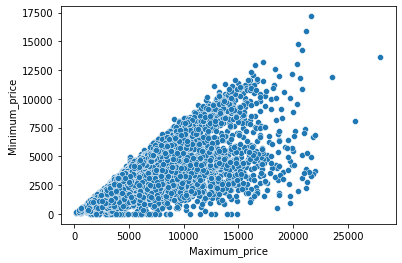

In [ ]:
sns.scatterplot(y=total_df['Minimum_price'],x=total_df['Maximum_price'])

In [ ]:
total_df[(total_df['Minimum_price']>19000) & (total_df['Minimum_price']>19000)]['Maximum_price'].median()

nan

In [33]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9737 non-null   object 
 1   Stall_no          9731 non-null   float64
 2   instock_date      9737 non-null   object 
 3   Market_Category   9737 non-null   int64  
 4   Loyalty_customer  9737 non-null   object 
 5   Product_Category  9737 non-null   object 
 6   Grade             9737 non-null   int64  
 7   Demand            9737 non-null   int64  
 8   Discount_avail    9737 non-null   float64
 9   charges_1         9737 non-null   float64
 10  charges_2 (%)     9737 non-null   float64
 11  Minimum_price     9685 non-null   float64
 12  Maximum_price     9396 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 989.0+ KB


In [356]:
def fill_min(cols):
  min_=cols[0]
  max_=cols[1]
  if pd.isnull(min_):
    return 0
    if max_<=10000:
      return 2890.0
    elif 10000<max_<=15000:
      return 6543.5
    elif 15000<max_<=20000:
      return 6826.0
  else:
    return min_

total_df['Minimum_price']=total_df[['Minimum_price','Maximum_price']].apply(fill_min,axis=1)

In [35]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9737 non-null   object 
 1   Stall_no          9731 non-null   float64
 2   instock_date      9737 non-null   object 
 3   Market_Category   9737 non-null   int64  
 4   Loyalty_customer  9737 non-null   object 
 5   Product_Category  9737 non-null   object 
 6   Grade             9737 non-null   int64  
 7   Demand            9737 non-null   int64  
 8   Discount_avail    9737 non-null   float64
 9   charges_1         9737 non-null   float64
 10  charges_2 (%)     9737 non-null   float64
 11  Minimum_price     9737 non-null   float64
 12  Maximum_price     9396 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 989.0+ KB


In [158]:
min_max=total_df[['Maximum_price','Minimum_price']]

In [159]:
min_max.head()

Maximum_price  Minimum_price
0         4713.0         2983.0
1        10352.0         7495.0
2         7309.0         5752.0
3        20814.0         5090.0
4         9261.0         2430.0

In [45]:
min_max.dropna(inplace=True)

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [49]:
knn_params={'n_neighbors':[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],'weights':['uniform','distance']}

In [50]:
knn_grid=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=knn_params,cv=6,verbose=2)

In [ ]:
knn_grid.fit(np.array(min_max['Minimum_price']).reshape(-1,1),min_max['Maximum_price'])

In [58]:
knn_grid.best_score_

0.5040402778702581

In [59]:
knn_grid.best_params_

{'n_neighbors': 40, 'weights': 'uniform'}

In [60]:
kn_fill=KNeighborsRegressor(n_neighbors=40)

In [61]:
kn_fill.fit(np.array(min_max['Minimum_price']).reshape(-1,1),min_max['Maximum_price'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                    weights='uniform')

In [357]:
def fill_max(cols):
  min_=cols[0]
  max_=cols[1]
  if pd.isnull(max_):
    return kn_fill.predict(np.array(min_).reshape(-1,1))
  else:
    return max_

total_df['Maximum_price']=total_df[['Minimum_price','Maximum_price']].apply(fill_max,axis=1)

In [ ]:
total_df.info()

In [ ]:
'''
def fill_max(cols):
  min_=cols[0]
  max_=cols[1]
  if pd.isnull(max_):
    if min_<=1000:
      return 2300
    elif 1000<min_<=5000:
      return 5059.0
    elif 5000<min_<=9000:
      return 9075.5
    elif 9000<min_<=14000:
      return 14477.5
    elif 14000<min_<=19000:
      return 21012.0
    elif min_>19000:
      return 25000
  else:
    return max_

total_df['Maximum_price']=total_df[['Minimum_price','Maximum_price']].apply(fill_max,axis=1)

In [ ]:
total_df['Stall_no'].value_counts().head(n=10)

20.0    226
32.0    224
12.0    219
25.0    218
9.0     214
14.0    211
28.0    210
33.0    210
2.0     208
48.0    205
Name: Stall_no, dtype: int64

In [ ]:
for i in [20.0,32.0,12.0,25.0,9.0,28.0,14.0,33.0,2.0,48.0]:
  print(total_df[total_df['Stall_no']==i]['Maximum_price'].median())

5272.0
5487.5
5693.0
5226.5
5466.0
5590.0
6122.0
5364.0
5260.0
5375.0


In [ ]:
total_df['Stall_no'].mode()

0    20.0
dtype: float64

In [358]:
##############*****************************
def fill_stall(cols):
  s=cols[0]
  m=cols[1]
  if pd.isnull(s):
    return 20.0
  else:
    return s
 
 
total_df['Stall_no']=total_df[['Stall_no','Maximum_price']].apply(fill_stall,axis=1)

In [ ]:
total_df.info()

In [389]:
loyal_cus={'Yes':1,'No ':0} # Loyalty Cust
total_df['Loyalty_customer']=total_df['Loyalty_customer'].map(loyal_cus)

In [390]:
# Product Cat
product_cat={'Pet_care':1,'Repair':2,'Child_care':3,'Cosmetics':4,'Educational':5,'Technology':6,'Hospitality':7,'Home_decor':8,'Organic':9,'Fashion':10}
total_df['Product_Category']=total_df['Product_Category'].map(product_cat)

In [71]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9737 non-null   object 
 1   Stall_no          9737 non-null   float64
 2   instock_date      9737 non-null   object 
 3   Market_Category   9737 non-null   int64  
 4   Loyalty_customer  9737 non-null   int64  
 5   Product_Category  9737 non-null   int64  
 6   Grade             9737 non-null   int64  
 7   Demand            9737 non-null   int64  
 8   Discount_avail    9737 non-null   float64
 9   charges_1         9737 non-null   float64
 10  charges_2 (%)     9737 non-null   float64
 11  Minimum_price     9737 non-null   float64
 12  Maximum_price     9737 non-null   object 
dtypes: float64(5), int64(5), object(3)
memory usage: 989.0+ KB


In [359]:
######### HANDLING DATES ###############
total_df['instock_date'] = pd.to_datetime(total_df.instock_date, format='%Y-%m-%d')

In [360]:
total_df['instock_year'] = total_df['instock_date'].dt.year
total_df['instock_month'] = total_df['instock_date'].dt.month
total_df['instock_week'] = total_df['instock_date'].dt.week
total_df['instock_Day'] = total_df['instock_date'].dt.day
total_df['instock_hour'] = total_df['instock_date'].dt.hour
total_df['instock_minute'] = total_df['instock_date'].dt.minute
total_df['instock_dayofweek'] = total_df['instock_date'].dt.dayofweek

In [361]:
total_df['date'] = pd.DatetimeIndex(total_df.instock_date).date

In [ ]:
# Max_min Difference

In [362]:
def get_diff(cols):
  return cols[0]-cols[1]
 
total_df['Max_min_dif']=total_df[['Maximum_price','Minimum_price']].apply(get_diff,axis=1)

In [363]:
train_data.shape

(6307, 15)

In [391]:
X_train=total_df[0:6307]
X_test=total_df[6307:]

# Feature Engineering

In [365]:
# RECENCY
import datetime as dt
today_date = dt.date(2016,3,30)

In [392]:
X_train['Recency'] = X_train.date.apply(lambda x : (today_date - x).days)
X_test['Recency'] = X_test.date.apply(lambda x : (today_date - x).days)

In [393]:
X_train=X_train.drop(['date','instock_date'],axis=1)
X_test=X_test.drop(['date','instock_date'],axis=1)

In [368]:
X_train.shape,X_test.shape

((6307, 21), (3430, 21))

In [394]:
X_train['Target']=Y

In [370]:
X_train.shape, X_test.shape

((6307, 22), (3430, 21))

# Using ProductID

In [177]:
X_train['Product_id']

0       BRAE2NF6JA5GUEXG
1       TUNE8SFB6RJN2HSD
2       BRAEAR7WZPQGPBZU
3       WATDZ2ZQ8JPDHCTJ
4       JWSEBUKYQPMBZ3RK
              ...       
6302    WATE7VE2D62VEKW8
6303    SHOEF9G8Z4ZXF6WE
6304    PBXEB9ZQ7HHCFXYG
6305    NKCEAGXHRYTNTMG7
6306    CAGE53FSAFWZRHFF
Name: Product_id, Length: 6307, dtype: object

In [178]:
def return_alps_3(id):
  return id[0:3]

def return_alps_4(id):
  return id[0:4]

def return_alps_5(id):
  return id[0:5]

In [395]:
X_train['ID_first3']=X_train['Product_id'].apply(return_alps_3)
X_train['ID_first4']=X_train['Product_id'].apply(return_alps_4)
X_train['ID_first5']=X_train['Product_id'].apply(return_alps_5)

In [87]:
X_train['ID_first3'].nunique(), X_train['ID_first4'].nunique()

(293, 322)

In [396]:
X_test['ID_first3']=X_test['Product_id'].apply(return_alps_3)
X_test['ID_first4']=X_test['Product_id'].apply(return_alps_4)
X_test['ID_first5']=X_test['Product_id'].apply(return_alps_5)

In [89]:
X_test['ID_first3'].nunique(), X_test['ID_first4'].nunique()

(243, 266)

### Feat Aggregation

In [90]:
def mean_encoder(var_name,target_name):
  var_unique=list(X_train[var_name].unique())
  var_dict={}
  for item in var_unique:
    value=X_train[X_train[var_name]==item][target_name].mean()
    var_dict.update([(item,value)])
  return var_dict

In [91]:
def median_encoder(var_name,target_name):
  var_unique=list(X_train[var_name].unique())
  var_dict={}
  for item in var_unique:
    value=X_train[X_train[var_name]==item][target_name].median()
    var_dict.update([(item,value)])
  return var_dict

In [93]:
def min_encoder(var_name,target_name):
  var_unique=list(X_train[var_name].unique())
  var_dict={}
  for item in var_unique:
    value=X_train[X_train[var_name]==item][target_name].min()
    var_dict.update([(item,value)])
  return var_dict

In [94]:
def max_encoder(var_name,target_name):
  var_unique=list(X_train[var_name].unique())
  var_dict={}
  for item in var_unique:
    value=X_train[X_train[var_name]==item][target_name].max()
    var_dict.update([(item,value)])
  return var_dict

In [207]:
def sum_encoder(var_name,target_name):
  var_unique=list(X_train[var_name].unique())
  var_dict={}
  for item in var_unique:
    value=X_train[X_train[var_name]==item][target_name].sum()
    var_dict.update([(item,value)])
  return var_dict

In [95]:
category_feats=['ID_first3','ID_first4','ID_first5','Stall_no','Loyalty_customer','Product_Category','Grade','Demand','Discount_avail','instock_year','instock_month','instock_week','instock_Day','instock_hour','instock_minute','instock_dayofweek']

In [397]:
for tar in ['Target','charges_1','charges_2 (%)','Minimum_price','Maximum_price']:
  for var in category_feats:
    X_train[var+'_mean']=X_train[var].map(mean_encoder(var,tar))
    X_test[var+'_mean']=X_test[var].map(mean_encoder(var,tar))
    X_train[var+'_median']=X_train[var].map(median_encoder(var,tar))
    X_train[var+'_min']=X_train[var].map(min_encoder(var,tar))
    X_train[var+'_max']=X_train[var].map(max_encoder(var,tar))
    X_train[var+'_sum']=X_train[var].map(sum_encoder(var,tar))
    X_test[var+'_sum']=X_test[var].map(sum_encoder(var,tar))
    X_test[var+'_median']=X_test[var].map(median_encoder(var,tar))
    X_test[var+'_min']=X_test[var].map(min_encoder(var,tar))
    X_test[var+'_max']=X_test[var].map(max_encoder(var,tar))

In [182]:
X_train.shape, X_test.shape

((6307, 89), (3430, 88))

In [183]:
def sub(cols):
  return cols[0]-cols[1]
 
def avg(cols):
  return (cols[0]+cols[1])/2

In [398]:
X_train['chr1_min_sub']=X_train[['Maximum_price','charges_1']].apply(sub,axis=1)
X_train['chr1_max_sub']=X_train[['Minimum_price','charges_1']].apply(sub,axis=1)
X_test['chr1_min_sub']=X_test[['Maximum_price','charges_1']].apply(sub,axis=1)
X_test['chr1_max_sub']=X_test[['Minimum_price','charges_1']].apply(sub,axis=1)
 
X_train['chr1_min_avg']=X_train[['Maximum_price','charges_1']].apply(avg,axis=1)
X_train['chr1_max_avg']=X_train[['Minimum_price','charges_1']].apply(avg,axis=1)
X_test['chr1_min_avg']=X_test[['Maximum_price','charges_1']].apply(avg,axis=1)
X_test['chr1_max_avg']=X_test[['Minimum_price','charges_1']].apply(avg,axis=1)

In [185]:
X_train.shape, X_test.shape

((6307, 93), (3430, 92))

In [399]:
for col in X_train.columns:
    try:
        X_train[col].replace([np.inf,-np.inf],np.nan,inplace=True)
        X_train[col]=X_train[col].fillna(np.mean(X_train[col]))
    except:
        continue

In [400]:
for cols in X_test.columns:
    try:
        X_test[cols].replace([np.inf,-np.inf],np.nan,inplace=True)
        X_test[cols]=X_test[cols].fillna(np.mean(X_test[cols]))
    except:
        continue

In [401]:
X_train.drop(['Product_id','ID_first3','ID_first4','ID_first5','Target'],axis=1,inplace=True)
X_test.drop(['Product_id','ID_first3','ID_first4','ID_first5'],axis=1,inplace=True)

In [262]:
X_train.shape,X_test.shape

((6307, 104), (3430, 104))

In [402]:
for cols in X_train.drop(['Loyalty_customer','Product_Category'],axis=1).columns:
  X_train[cols]=X_train[cols].apply(lambda x: float(x))

In [403]:
for cols in X_test.drop(['Loyalty_customer','Product_Category'],axis=1).columns:
  X_test[cols]=X_test[cols].apply(lambda x: float(x))

In [381]:
X_train

Stall_no  Market_Category  ... chr1_min_avg chr1_max_avg
0         37.0              2.0  ...       2544.5       1679.5
1         38.0             24.0  ...       5374.5       3946.0
2          9.0            447.0  ...       3779.5       3001.0
3         50.0             23.0  ...      10479.0       2617.0
4          7.0             63.0  ...       4736.0       1320.5
...        ...              ...  ...          ...          ...
6302      17.0             24.0  ...       5940.0       4394.0
6303      21.0             55.0  ...       2594.5       1916.5
6304      36.0            358.0  ...       7448.5       2793.0
6305      27.0            452.0  ...       3058.0       2300.5
6306      11.0             58.0  ...       2998.5       2294.5

[6307 rows x 104 columns]

# Make Metrics

In [105]:
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error

def RMSLE(y_true,y_pred):
  score=mean_squared_log_error(y_true,np.abs(y_pred))
  root_square=score**(0.5)
  return max(0,(100-root_square*100))

rmlse_score=make_scorer(RMSLE)

# Feature Selection

## Kbest

In [504]:
from sklearn.model_selection import cross_val_score, RepeatedKFold, RepeatedStratifiedKFold,KFold
from sklearn.feature_selection import SelectKBest,chi2,f_regression
kbest_model=lgb.LGBMRegressor()
kbest_cb_model=cb.CatBoostRegressor(iterations=55,verbose=0)
knn=KNeighborsRegressor(n_neighbors=11)

In [505]:
k_nums=list(range(1,95))
scores=[]
variances=[]
for ks in k_nums:
  kbest = SelectKBest(f_regression, k=ks).fit_transform(X_train,Y)
  acus=cross_val_score(estimator=knn,X=kbest,y=Y,scoring=rmlse_score,cv=cv_5)
  score=acus.mean()
  var=acus.std()
  scores.append(score)
  variances.append(var)

In [506]:
variances=np.array(variances)
mm=variances.max()

final_var=[]
for i in variances:
  j=i/mm
  final_var.append(j*100)


Text(0, 0.5, 'RMSLE Score')

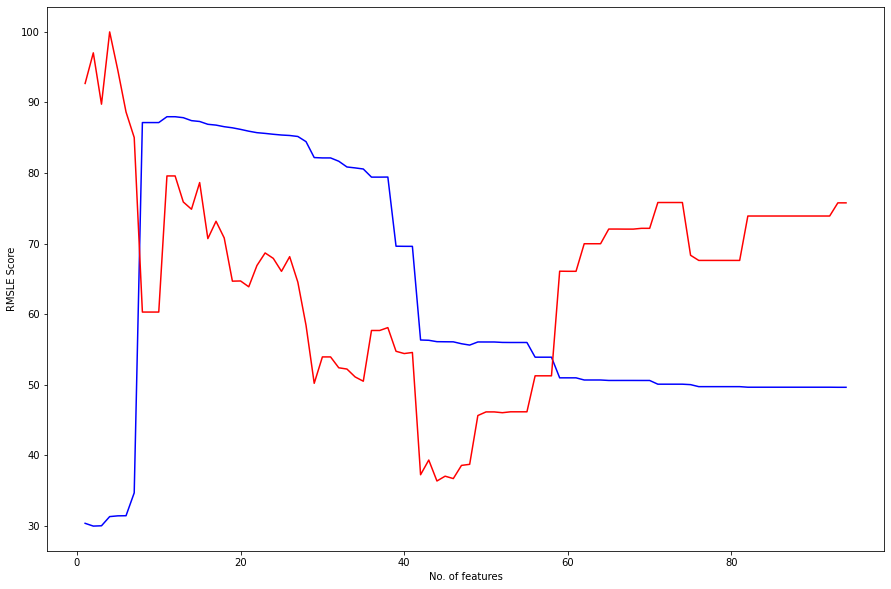

In [507]:
fig=plt.figure(figsize=(15,10))
plt.plot(k_nums,scores,'b')
plt.plot(k_nums,final_var,'r')
plt.xlabel('No. of features')
plt.ylabel('RMSLE Score')

In [522]:
scores[11]

87.97742747489507

In [523]:
lgb_feat_selector = SelectKBest(f_regression, k=11)
lgb_feat_selector.fit(X_train, Y)
lgb_kbestcols = lgb_feat_selector.get_support(indices=True)
lgb_imp_features = X_train.iloc[:,lgb_kbestcols].columns

In [524]:
lgb_imp_features

Index(['Discount_avail', 'Minimum_price', 'Maximum_price',
       'Discount_avail_mean', 'Discount_avail_min', 'Discount_avail_max',
       'Discount_avail_sum', 'chr1_min_sub', 'chr1_max_sub', 'chr1_min_avg',
       'chr1_max_avg'],
      dtype='object')

### Testing Kbest on Basic regression models

In [ ]:
from sklearn.linear_model import BayesianRidge, Ridge, Lasso, LassoLars

In [ ]:
models=[BayesianRidge(),Ridge(),Lasso(),LassoLars()]

In [ ]:
model_scores=[]
for model in models:
  k_nums=list(range(1,59))
  scores=[]
  for ks in k_nums:
    kbest = SelectKBest(f_regression, k=ks).fit_transform(X_train.drop('Product_id',axis=1),Y)
    score=cross_val_score(estimator=model,X=kbest,y=Y,scoring=rmlse_score,cv=5).mean()
    scores.append(score)
  model_scores.append(scores)

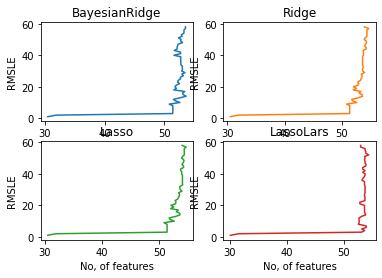

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(model_scores[0], k_nums,'tab:blue')
axs[0, 0].set_title('BayesianRidge')
axs[0, 1].plot(model_scores[1], k_nums, 'tab:orange')
axs[0, 1].set_title('Ridge')
axs[1, 0].plot(model_scores[2], k_nums, 'tab:green')
axs[1, 0].set_title('Lasso')
axs[1, 1].plot(model_scores[3], k_nums, 'tab:red')
axs[1, 1].set_title('LassoLars')

for ax in axs.flat:
    ax.set(xlabel='No, of features', ylabel='RMSLE')


### Random forest Kbest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
kbest_rf=RandomForestRegressor()

In [ ]:
scores=[]
for ks in k_nums:
  kbest = SelectKBest(f_regression, k=ks).fit_transform(X_train,Y)
  score=cross_val_score(estimator=kbest_rf,X=kbest,y=Y,scoring=rmlse_score,cv=5).mean()
  scores.append(score)

In [ ]:
fig=plt.figure(figsize=(15,10))
plt.plot(k_nums,scores)
plt.xlabel('No. of features')
plt.ylabel('RMSLE Score')

## Forward Selection

### LGBM

In [107]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
cv_5 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
e=2.7182818284590452353602874713527

In [121]:
lgbm_forward_seqselector = SFS(kbest_model, scoring=rmlse_score,verbose=2, k_features=95, forward=True,cv=cv_5)
lgbm_forward_seqselector.fit(X_train,Y,custom_feature_names=list(X_train.columns))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:   27.5s finished

[2020-12-04 11:41:53] Features: 1/95 -- score: 44.14598749340773[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:   31.0s finished

[2020-12-04 11:42:24] Features: 2/95 -- score: 83.32782205229498[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:   41.7s finished

[2020-12-04 11:43:06] Features: 3/95 -- score: 87.83783601469129[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

SequentialFeatureSelector(clone_estimator=True,
                          cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
                          estimator=LGBMRegressor(boosting_type='gbdt',
                                                  class_weight=None,
                                                  colsample_bytree=1.0,
                                                  importance_type='split',
                                                  learning_rate=0.1,
                                                  max_depth=-1,
                                                  min_child_samples=20,
                                                  min_child_weight=0.001,
                                                  min_split_gain=0.0,
                                                  n_estimators=100, n_jobs=-1,
                                                  num_leaves=31, objective=None,
                                                  random_state=None,


In [122]:
lgb_forward_feats=list(lgbm_forward_seqselector.k_feature_names_)

In [123]:
lgb_forward_feats

['Loyalty_customer',
 'Product_Category',
 'Discount_avail',
 'Minimum_price',
 'instock_month',
 'Stall_no_mean',
 'Loyalty_customer_mean',
 'Loyalty_customer_median',
 'Loyalty_customer_min',
 'Loyalty_customer_max',
 'Loyalty_customer_sum',
 'Grade_mean',
 'Grade_median',
 'Discount_avail_mean',
 'Discount_avail_median',
 'Discount_avail_min',
 'Discount_avail_max',
 'Discount_avail_sum',
 'instock_year_mean',
 'instock_week_min',
 'instock_dayofweek_sum',
 'chr1_min_avg']

In [126]:
lgb_imp_features

Index(['Discount_avail', 'Minimum_price', 'Maximum_price', 'Max_min_dif',
       'ID_first5_mean', 'ID_first5_median', 'Discount_avail_mean',
       'Discount_avail_median', 'Discount_avail_min', 'Discount_avail_max',
       'Discount_avail_sum', 'instock_month_mean', 'instock_week_mean',
       'instock_week_median', 'chr1_min_sub', 'chr1_max_sub', 'chr1_min_avg',
       'chr1_max_avg'],
      dtype='object')

In [130]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6307 entries, 0 to 6306
Columns: 104 entries, Stall_no to chr1_max_avg
dtypes: float64(44), int64(13), object(47)
memory usage: 5.0+ MB


### CatBoost

In [ ]:
cb_forward_seqselector = SFS(kbest_cb_model, scoring=rmlse_score,verbose=2, k_features=50, forward=True,cv=cv_5)
cb_forward_seqselector.fit(X_train,Y,custom_feature_names=list(X_train.columns))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:   51.1s finished

[2020-12-04 00:03:36] Features: 1/50 -- score: 44.162950663823864[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:   51.7s finished

[2020-12-04 00:04:27] Features: 2/50 -- score: 82.63656541298734[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(clone_estimator=True,
                          cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
                          estimator=<catboost.core.CatBoostRegressor object at 0x7fb2d0cfe048>,
                          floating=False, forward=True, k_features=50, n_jobs=1,
                          pre_dispatch='2*n_jobs', scoring=make_scorer(RMSLE),
                          verbose=2)

In [ ]:
cb_forward_feats=list(cb_forward_seqselector.k_feature_names_)

In [ ]:
cb_forward_feats=cb_forward_feats[0:4]

In [ ]:
cb_forward_feats

['Discount_avail', 'Recency', 'ID_first5_sum', 'Grade_min']

### Xgboost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_test=xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.05)

In [ ]:
xgb_seqselector = SFS(xgb_test,scoring=rmlse_score,verbose=2, k_features=50, forward=True,cv=cv_5)
xgb_seqselector.fit(X_train,Y,custom_feature_names=list(X_train.columns))
xgb_seq_score=xgb_seqselector.k_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  1.0min finished

[2020-12-03 14:10:43] Features: 1/50 -- score: 43.6914621580006[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  1.1min finished

[2020-12-03 14:11:50] Features: 2/50 -- score: 80.3579137030502[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:  1.5min finished

[2020-12-03 14:13:22] Features: 3/50 -- score: 83.18720449034302[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 ou

In [ ]:
xgb_forward_feats=list(xgb_seqselector.k_feature_names_)

In [ ]:
xgb_forward_feats

['Discount_avail',
 'charges_2 (%)',
 'Maximum_price',
 'Discount_avail_mean',
 'Discount_avail_median',
 'Discount_avail_sum',
 'instock_month_max',
 'instock_dayofweek_mean',
 'instock_dayofweek_min',
 'chr1_max_avg']

# GridSearchCV + Xgboost

In [ ]:
xgb_params={'n_estimators':[110,120,130,140],'learning_rate':np.linspace(0.02,0.05,10),'max_depth':[5,6,7,8]}

In [ ]:
xgb_grid=GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),param_grid=xgb_params,scoring=rmlse_score,cv=cv_5,verbose=2)

In [ ]:
xgb_grid.fit(X_train[lgb_forward_feats],Y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] learning_rate=0.02, max_depth=5, n_estimators=110 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.02, max_depth=5, n_estimators=110, total=   0.8s
[CV] learning_rate=0.02, max_depth=5, n_estimators=110 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.02, max_depth=5, n_estimators=110, total=   0.6s
[CV] learning_rate=0.02, max_depth=5, n_estimators=110 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=110, total=   0.6s
[CV] learning_rate=0.02, max_depth=5, n_estimators=110 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=110, total=   0.6s
[CV] learning_rate=0.02, max_depth=5, n_estimators=110 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=110, total=   0.6s
[CV] learning_rate=0.02, max_depth=5, n_estimators=120 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=120, total=   0.7s
[CV] learning_rate=0.02, max_depth=5, n_estimators=120 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=120, total=   0.7s
[CV] learning_rate=0.02, max_depth=5, n_estimators=120 ...............
[CV]  learning_rate=0.02, max_depth=5, n_estimators=120, total=   0.7s
[CV] learning_rate=0.02, max_depth=5, n_estimators=120 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 13.2min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    ob...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667

In [ ]:
xgb_grid.best_score_

88.80774725755714

In [ ]:
xgb_grid.best_params_

{'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 140}

In [ ]:
xgb_model=xgb.XGBRegressor(max_depth=6,learning_rate=0.04,n_estimators=140,objective='reg:squarederror')

In [ ]:
xgb_model.fit(X_train[lgb_forward_feats],np.log1p(Y))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred=xgb_model.predict(X_test[lgb_forward_feats])

In [ ]:
xgb_pred

array([8.060673 , 7.4985776, 9.326465 , ..., 8.705368 , 8.09116  ,
       6.880547 ], dtype=float32)

In [ ]:
xgb_pred_df=pd.DataFrame({'Product_id':test_data['Product_id'],'Selling_Price':(e**xgb_pred)*1.025})

In [ ]:
xgb_pred_df.head()

Product_id  Selling_Price
0  SCHE4YSTDVPVZVXW    3246.604980
1  ACCEGCATKHNRXUHW    1850.608765
2  NKCE6GJ5XVJDXNNZ   11512.134766
3  NKCEB8BK3ZXDHDHM    9561.003906
4  TOPEFDXSAHRNPF94    5608.651367

In [ ]:
xgb_pred_df.to_csv('xgb26.csv',index=False)

# GridSearch + LGBM

In [268]:
lgb_params={'num_leaves':[29,30,31,32,33,34,35,36,37,38,39],'max_depth':[6,7,8],'learning_rate':np.linspace(0.05,0.10,10)}

In [269]:
lgb_grid=GridSearchCV(estimator=lgb.LGBMRegressor(),param_grid=lgb_params,scoring=rmlse_score,cv=cv_5,verbose=2)

In [273]:
lgb_grid.fit(X_train[lgb_forward_feats],Y)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits
[CV] learning_rate=0.05, max_depth=6, num_leaves=29 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=29, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=29 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ... learning_rate=0.05, max_depth=6, num_leaves=29, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=29 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=29, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=29 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=29, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=29 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=29, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=30 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=30, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=30 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=30, total=   0.1s
[CV] learning_rate=0.05, max_depth=6, num_leaves=30 ..................
[CV] ... learning_rate=0.05, max_depth=6, num_leaves=30, total=   0.2s
[CV] learning_rate=0.05, max_depth=6, num_leaves=30 ..................
[CV] .

[Parallel(n_jobs=1)]: Done 1650 out of 1650 | elapsed:  4.1min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random...
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.05      , 0.05555556, 0.06111111, 0.06666667, 0.07222222,
       0.07777778, 0.08333333, 0.08888889, 0.09444444, 0.1       ]),
                         

In [274]:
lgb_grid.best_score_

88.5693349510727

In [275]:
lgb_grid.best_params_

{'learning_rate': 0.07222222222222223, 'max_depth': 6, 'num_leaves': 34}

In [ ]:
lgb_forward_feats

['Loyalty_customer',
 'Discount_avail',
 'Minimum_price',
 'Maximum_price',
 'instock_year',
 'instock_Day',
 'Loyalty_customer_mean',
 'Loyalty_customer_median',
 'Loyalty_customer_min',
 'Loyalty_customer_max',
 'Loyalty_customer_sum',
 'Grade_mean',
 'Grade_sum',
 'chr1_min_avg']

In [276]:
from sklearn.model_selection import train_test_split

In [277]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y, test_size=0.2, random_state=101)

In [315]:
lgb_train=lgb.Dataset(x_train[lgb_forward_feats],label=y_train)

In [316]:
lgb_valid=lgb.Dataset(x_valid[lgb_forward_feats],label=y_valid)

In [317]:
params_lgb={'learning_rate':0.09555555555555556, 'max_depth':7, 'num_leaves':36,'early_stopping_round':250,'num_iterations': 1000,'objective': 'regression'}

In [ ]:
lgbm_traiin = lgb.train(params=params_lgb, verbose_eval=300, train_set=lgb_train, valid_sets=[lgb_valid])

In [325]:
y_predd=lgbm_traiin.predict(x_valid[lgb_forward_feats])

In [326]:
y_predd*1.006

array([5871.91066746, 1918.39987523, 4087.64003877, ...,  579.97802574,
       2358.06386884, 3186.7431391 ])

In [322]:
from sklearn.metrics import mean_squared_error

In [327]:
mean_squared_error(y_valid,y_predd*1.006)

164245.27546432897

In [330]:
164245.27546432897**(0.5)

405.27185377759577

In [ ]:
lgb_model=lgb.LGBMRegressor(num_leaves=38,max_depth=8,learning_rate=0.094444444444445,loss_function='RMSLE')

In [ ]:
lgb_model.fit(X_train[lgb_forward_feats],np.log1p(Y)) #np.log1p(Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.094444444444445,
              loss_function='RMSLE', max_depth=8, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=38, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb_pred=lgb_model.predict(X_test[lgb_forward_feats])

In [ ]:
lgb_pred

array([8.11435151, 7.53699267, 9.35402647, ..., 8.73843075, 8.0938588 ,
       6.92018693])

In [ ]:
lgb_pred_df=pd.DataFrame({'Product_id':test_data['Product_id'],'Selling_Price':e**lgb_pred})

In [ ]:
lgb_pred_df.head()

Product_id  Selling_Price
0  SCHE4YSTDVPVZVXW    3342.089585
1  ACCEGCATKHNRXUHW    1876.179241
2  NKCE6GJ5XVJDXNNZ   11545.216444
3  NKCEB8BK3ZXDHDHM    9611.868133
4  TOPEFDXSAHRNPF94    5532.460273

In [ ]:
lgb_pred_df.to_csv('lgb66.csv',index=False)

# GridsearchCV+Catboost

In [411]:
X_train["Discount_avail"] = X_train["Discount_avail"].astype(np.int) 
X_train["instock_month"] = X_train["instock_month"].astype(np.int) 
X_train["Loyalty_customer"] = X_train["Loyalty_customer"].astype(np.int) 
X_train["Product_Category"] = X_train["Product_Category"].astype(np.int) 

In [429]:
X_test["Discount_avail"] = X_test["Discount_avail"].astype(np.int) 
X_test["instock_month"] = X_test["instock_month"].astype(np.int) 
X_test["Loyalty_customer"] = X_test["Loyalty_customer"].astype(np.int) 
X_test["Product_Category"] = X_test["Product_Category"].astype(np.int) 

In [442]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train[lgb_forward_feats], np.log1p(Y), test_size=0.25, random_state=42)

In [443]:
params = {'loss_function':'RMSE', # objective function
         # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': 42
         }

In [444]:
cbc_1 = cb.CatBoostRegressor(**params)
cbc_1.fit(x_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(x_valid, y_valid), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.061807
0:	learn: 0.8083186	test: 0.7949386	best: 0.7949386 (0)	total: 6.44ms	remaining: 6.44s
200:	learn: 0.0936720	test: 0.0990966	best: 0.0990074 (146)	total: 546ms	remaining: 2.17s
400:	learn: 0.0704558	test: 0.1001312	best: 0.0989563 (211)	total: 1.07s	remaining: 1.59s
600:	learn: 0.0577515	test: 0.1010070	best: 0.0989563 (211)	total: 1.53s	remaining: 1.02s
800:	learn: 0.0495757	test: 0.1012415	best: 0.0989563 (211)	total: 2.05s	remaining: 509ms
999:	learn: 0.0436944	test: 0.1017995	best: 0.0989563 (211)	total: 2.51s	remaining: 0us

bestTest = 0.09895627781
bestIteration = 211

Shrink model to first 212 iterations.


In [448]:
preds=cbc_1.predict(X_test[lgb_forward_feats])

In [450]:
preds

array([8.06987248, 7.55856157, 9.38080592, ..., 8.68485502, 8.14940088,
       6.88250032])

In [ ]:
lgb_forward_feats

In [413]:
cat_feats=[0,1,2,4]

In [445]:
params = {'loss_function':'RMSE',
          'cat_features': cat_feats,
          'verbose': 200,
          'random_seed': 42
         }
cbc_2 =cb.CatBoostRegressor(**params)
cbc_2.fit(x_train, y_train,
          eval_set=(x_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.061807
0:	learn: 0.8126855	test: 0.7989976	best: 0.7989976 (0)	total: 8.01ms	remaining: 8.01s
200:	learn: 0.1009429	test: 0.1003568	best: 0.1000286 (152)	total: 1.17s	remaining: 4.64s
400:	learn: 0.0821161	test: 0.1012617	best: 0.1000286 (152)	total: 2.17s	remaining: 3.24s
600:	learn: 0.0703118	test: 0.1022555	best: 0.1000286 (152)	total: 3.2s	remaining: 2.13s
800:	learn: 0.0631244	test: 0.1024286	best: 0.1000286 (152)	total: 4.2s	remaining: 1.04s
999:	learn: 0.0570896	test: 0.1028048	best: 0.1000286 (152)	total: 5.25s	remaining: 0us

bestTest = 0.1000285755
bestIteration = 152

Shrink model to first 153 iterations.


In [446]:
params = {'loss_function':'RMSE',
          'cat_features': cat_feats,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42
         }
cbc_2 = cb.CatBoostRegressor(**params)
cbc_2.fit(x_train, y_train, 
          eval_set=(x_valid, y_valid), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.061807
0:	learn: 0.8126855	test: 0.7989976	best: 0.7989976 (0)	total: 4.39ms	remaining: 4.39s
200:	learn: 0.1009429	test: 0.1003568	best: 0.1000286 (152)	total: 1.18s	remaining: 4.68s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1000285755
bestIteration = 152

Shrink model to first 153 iterations.


In [431]:
pred=cbc_2.predict(X_test[lgb_forward_feats])

In [298]:
cb_params={'iterations':[56,57,58,59,60,61,62,63,64,65,66],'depth':[5,6,7],'learning_rate':np.linspace(0.07,0.14,20),'verbose':[0]}

In [299]:
cb_grid=GridSearchCV(estimator=cb.CatBoostRegressor(),param_grid=cb_params,scoring=rmlse_score,cv=cv_5,verbose=2)

In [300]:
cb_grid.fit(X_train[lgb_forward_feats],Y)

Fitting 5 folds for each of 660 candidates, totalling 3300 fits
[CV] depth=5, iterations=56, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=56, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=56, learning_rate=0.07, verbose=0 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] depth=5, iterations=64, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=64, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=64, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=64, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=64, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.07, verbose=0 ...........
[CV]  depth=5, iterations=64, learning_rate=0.07, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.0736842105263158, verbose=0 
[CV]  depth=5, iterations=64, learning_rate=0.0736842105263158, verbose=0, total=   0.2s
[CV] depth=5, iterations=64, learning_rate=0.07368421052

[Parallel(n_jobs=1)]: Done 3300 out of 3300 | elapsed: 11.0min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f076f35d588>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [5, 6, 7],
                         'iterations': [56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                                        66],
                         'learning_rate': array([0.07      , 0.07368421, 0.07736842, 0.08105263, 0.08473684,
       0.08842105, 0.09210526, 0.09578947, 0.09947368, 0.10315789,
       0.10684211, 0.11052632, 0.11421053, 0.11789474, 0.12157895,
       0.12526316, 0.12894737, 0.13263158, 0.13631579, 0.14      ]),
                         'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSLE), verbose=2)

In [301]:
cb_grid.best_score_

88.10466074377604

In [ ]:
cb_grid.best_params_

{'depth': 6,
 'iterations': 64,
 'learning_rate': 0.12157894736842106,
 'verbose': 0}

In [422]:
cb_model=cb.CatBoostRegressor(iterations=546,learning_rate=0.061807,eval_metric='MSLE')

In [423]:
cb_model.fit(X_train[lgb_forward_feats],np.log1p(Y))

0:	learn: 0.0089136	total: 3.5ms	remaining: 1.91s
1:	learn: 0.0080366	total: 6.76ms	remaining: 1.84s
2:	learn: 0.0072591	total: 9.58ms	remaining: 1.73s
3:	learn: 0.0065247	total: 12.4ms	remaining: 1.68s
4:	learn: 0.0058693	total: 15.1ms	remaining: 1.64s
5:	learn: 0.0053036	total: 17.9ms	remaining: 1.61s
6:	learn: 0.0048114	total: 20.9ms	remaining: 1.61s
7:	learn: 0.0043526	total: 23.6ms	remaining: 1.59s
8:	learn: 0.0039251	total: 26.4ms	remaining: 1.58s
9:	learn: 0.0035295	total: 29.3ms	remaining: 1.57s
10:	learn: 0.0031813	total: 32.1ms	remaining: 1.56s
11:	learn: 0.0028774	total: 34.9ms	remaining: 1.55s
12:	learn: 0.0026105	total: 37.7ms	remaining: 1.55s
13:	learn: 0.0023614	total: 40.5ms	remaining: 1.54s
14:	learn: 0.0021453	total: 43.3ms	remaining: 1.53s
15:	learn: 0.0019539	total: 46.3ms	remaining: 1.53s
16:	learn: 0.0017808	total: 49.1ms	remaining: 1.53s
17:	learn: 0.0016232	total: 51.9ms	remaining: 1.52s
18:	learn: 0.0014803	total: 54.7ms	remaining: 1.52s
19:	learn: 0.0013498	to

In [424]:
cb_preds=cb_model.predict(X_test[lgb_forward_feats])

In [453]:
cb_pred_df=pd.DataFrame({'Product_id':test_data['Product_id'],'Selling_Price':e**preds})

In [454]:
cb_pred_df.head()

Product_id  Selling_Price
0  SCHE4YSTDVPVZVXW    3196.694176
1  ACCEGCATKHNRXUHW    1917.085926
2  NKCE6GJ5XVJDXNNZ   11858.567968
3  NKCEB8BK3ZXDHDHM    9562.823598
4  TOPEFDXSAHRNPF94    5614.804016

In [455]:
cb_pred_df.to_csv('cb9.csv',index=False)

# High Score Submission details

In [ ]:
sub_dict={
    'Model_name':['LGBM','LGBM'],
    'Feature Selection Type':['kbest','Forward Selection'],
    'Num_feats_selected':[43,6],
    'Learning Rate':[0.07421052631578948,0.08777777857142857],
    'Num_leaves(lgbm)':[49,26],
    'Max_depth(lgbm)':[12,6],
    'GridSearchScore':[89.48,89.75],
    'LeaderBoardScore(with log)':[89.54,89.79]
}

In [ ]:
Submissions_df=pd.DataFrame(sub_dict)

In [ ]:
Submissions_df

Model_name  ... LeaderBoardScore(with log)
0       LGBM  ...                      89.54
1       LGBM  ...                      89.79

[2 rows x 8 columns]

# Stacking

In [435]:
l1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lgb37.csv')
l2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lgb4.csv')
l3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lgb5.csv')

In [461]:
l1.Selling_Price

0        3219.629553
1        1913.679189
2       11637.898000
3        9552.353940
4        5659.874189
            ...     
3425     3990.133829
3426     9102.267782
3427     5834.879393
3428     3529.644124
3429     1003.641243
Name: Selling_Price, Length: 3430, dtype: float64

In [560]:
new=(l1.Selling_Price)*0.8+(e**knn_pred)*0.2

In [561]:
new

0        3218.259595
1        1912.659609
2       11610.061003
3        9503.572137
4        5613.333443
            ...     
3425     3993.657459
3426     9077.969089
3427     5909.705784
3428     3496.674477
3429     1003.555551
Name: Selling_Price, Length: 3430, dtype: float64

In [562]:
stk_pred_df=pd.DataFrame({'Product_id':test_data['Product_id'],'Selling_Price':new})

In [563]:
stk_pred_df.head()

Product_id  Selling_Price
0  SCHE4YSTDVPVZVXW    3218.259595
1  ACCEGCATKHNRXUHW    1912.659609
2  NKCE6GJ5XVJDXNNZ   11610.061003
3  NKCEB8BK3ZXDHDHM    9503.572137
4  TOPEFDXSAHRNPF94    5613.333443

In [564]:
stk_pred_df.to_csv('stk_pred47.csv',index=False)

# Total Data Predict

In [ ]:
X_train_virtu=X_train.copy()
X_test_virtu=X_test.copy()

In [ ]:
X_train_virtu['Target']=Y
X_test_virtu['Target']=e**lgb_pred

In [ ]:
X_train_virtu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6350 entries, 0 to 6349
Data columns (total 86 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Product_id                6350 non-null   object 
 1   Stall_no                  6350 non-null   float64
 2   Market_Category           6350 non-null   int64  
 3   Loyalty_customer          6350 non-null   int64  
 4   Product_Category          6350 non-null   int64  
 5   Grade                     6350 non-null   int64  
 6   Demand                    6350 non-null   int64  
 7   Discount_avail            6350 non-null   float64
 8   charges_1                 6350 non-null   float64
 9   charges_2 (%)             6350 non-null   float64
 10  Minimum_price             6350 non-null   float64
 11  Maximum_price             6350 non-null   float64
 12  instock_year              6350 non-null   int64  
 13  instock_month             6350 non-null   int64  
 14  instock_

In [ ]:
X_train_virtu.shape, X_test_virtu.shape

((6350, 86), (3430, 86))

In [ ]:
total_virtu_df=pd.concat([X_train_virtu,X_test_virtu],axis=0)

In [ ]:
total_virtu_df.shape

(9780, 86)

In [ ]:
total_virtu_df.info()

In [ ]:
total_virtu_df['Target']=total_virtu_df['Target'].fillna(total_virtu_df['Target'].mean())

In [ ]:
total_lgb_params={'num_leaves':[30,31,32,33,34],'max_depth':[5,6,7,8,9],'learning_rate':np.linspace(0.06,0.12,15)}

In [ ]:
total_lgb_grid=GridSearchCV(estimator=lgb.LGBMRegressor(),param_grid=total_lgb_params,scoring=rmlse_score,cv=cv_5,verbose=2)

In [ ]:
total_lgb_grid.fit(total_virtu_df[lgb_forward_feats],total_virtu_df['Target'])

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
[CV] learning_rate=0.06, max_depth=5, num_leaves=30 ..................
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=30, total=   0.1s
[CV] learning_rate=0.06, max_depth=5, num_leaves=30 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ... learning_rate=0.06, max_depth=5, num_leaves=30, total=   0.1s
[CV] learning_rate=0.06, max_depth=5, num_leaves=30 ..................
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=30, total=   0.1s
[CV] learning_rate=0.06, max_depth=5, num_leaves=30 ..................
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=30, total=   0.1s
[CV] learning_rate=0.06, max_depth=5, num_leaves=30 ..................
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=30, total=   0.2s
[CV] learning_rate=0.06, max_depth=5, num_leaves=31 ..................
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=31, total=   0.1s
[CV] learning_rate=0.06, max_depth=5, num_leaves=31 ..................
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[CV] ... learning_rate=0.06, max_depth=5, num_leaves=31, total=   0.1s
[CV] learning_r

[Parallel(n_jobs=1)]: Done 1875 out of 1875 | elapsed:  4.9min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=10),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random...
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.06      , 0.06428571, 0.06857143, 0.07285714, 0.07714286,
       0.08142857, 0.08571429, 0.09      , 0.09428571, 0.09857143,
       0.10285714, 0.10714286, 0.11142857, 0.11571429, 0.12      ]),
                         'max_depth': [5, 6, 7, 8, 9],
                         'num_leaves'

In [ ]:
total_lgb_grid.best_score_

14.39838789596065

In [ ]:
total_lgb_grid.best_params_

{'learning_rate': 0.06428571428571428, 'max_depth': 5, 'num_leaves': 31}

# Using KNN

In [490]:
from sklearn.neighbors import KNeighborsRegressor

In [535]:
knn_params={'n_neighbors':list(range(10,20)),'algorithm':['ball_tree','kd_tree','brute','auto']}

In [536]:
knn_grid=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=knn_params,cv=cv_5,verbose=2,scoring=rmlse_score)

In [537]:
knn_grid.fit(X_train[lgb_imp_features],Y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] algorithm=ball_tree, n_neighbors=10 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=10, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=10 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=10, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=10 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=10, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=10 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=10, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=10 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............. algorithm=ball_tree, n_neighbors=10, total=   0.1s
[CV] algorithm=ball_tree, n_neighbors=11 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=11, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=11 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=11, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=11 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=11, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=11 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=11, total=   0.1s
[CV] algorithm=ball_tree, n_neighbors=11 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=11, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=12 .............................
[CV] .............. algorithm=ball_tree, n_neighbors=12, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=12 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.1s finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                         19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSLE), verbose=2)

In [538]:
knn_grid.best_score_

88.07152095182089

In [539]:
knn_grid.best_params_

{'algorithm': 'brute', 'n_neighbors': 14}

In [540]:
knn_model=KNeighborsRegressor(n_neighbors=14,algorithm='brute')

In [541]:
knn_model.fit(X_train[lgb_imp_features],np.log1p(Y))

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                    weights='uniform')

In [542]:
knn_pred=knn_model.predict(X_test[lgb_imp_features])

In [544]:
e**knn_pred

array([ 3212.77976384,  1908.5812902 , 11498.71301416, ...,
        6209.01134585,  3364.79589134,  1003.21278055])